In [1]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datasets import load_dataset
import spacy
from spacy.pipeline import EntityRuler
from collections import Counter
from sklearn.metrics import classification_report
import seaborn as sns
from tqdm import tqdm
from seqeval.metrics import classification_report as seq_classification_report
from seqeval.metrics import precision_score, recall_score, f1_score
from collections import defaultdict

from src.patterns import ORG_KEYWORDS, ORG_SUFFIXES, COUNTRIES, CITIES, STATES_USA

c:\Users\–ü–æ–ª—å–∑–æ–≤–∞—Ç–µ–ª—å\Desktop\—É—á–µ–±–∞\–ö–æ–º–ø—å—é—Ç–µ—Ä–Ω–∞—è –ª–∏–Ω–≥–≤–∏—Å—Ç–∏–∫–∞ –î–æ—Å–æ–≤\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
!python -m spacy download en_core_web_sm

     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
      --------------------------------------- 0.2/12.8 MB 3.1 MB/s eta 0:00:05
     - -------------------------------------- 0.4/12.8 MB 3.2 MB/s eta 0:00:04
     -- ------------------------------------- 0.9/12.8 MB 4.9 MB/s eta 0:00:03
     ---- ----------------------------------- 1.4/12.8 MB 6.4 MB/s eta 0:00:02
     ------ --------------------------------- 1.9/12.8 MB 7.3 MB/s eta 0:00:02
     ------- -------------------------------- 2.4/12.8 MB 8.1 MB/s eta 0:00:02
     --------- ------------------------------ 2.9/12.8 MB 8.5 MB/s eta 0:00:02
     ----------- ---------------------------- 3.6/12.8 MB 9.1 MB/s eta 0:00:02
     ------------ --------------------------- 4.1/12.8 MB 9.4 MB/s eta 0:00:01
     -------------- ------------------------- 4.7/12.8 MB 9.6 MB/s eta 0:00:01
     ---------------- ----------------------- 5.2/12.8 MB 9.8 MB/s


[notice] A new release of pip is available: 24.0 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
dataset = load_dataset(
    "tner/ontonotes5",
    data_dir="ontonotes5",              
    revision="refs/convert/parquet"  
)

In [4]:
train = dataset["train"]
val = dataset["validation"]
test = dataset["test"]

In [5]:
LABEL_TO_ID = {
    "O": 0,
    "B-CARDINAL": 1,
    "B-DATE": 2,
    "I-DATE": 3,
    "B-PERSON": 4,
    "I-PERSON": 5,
    "B-NORP": 6,
    "B-GPE": 7,
    "I-GPE": 8,
    "B-LAW": 9,
    "I-LAW": 10,
    "B-ORG": 11,
    "I-ORG": 12, 
    "B-PERCENT": 13,
    "I-PERCENT": 14, 
    "B-ORDINAL": 15, 
    "B-MONEY": 16, 
    "I-MONEY": 17, 
    "B-WORK_OF_ART": 18, 
    "I-WORK_OF_ART": 19, 
    "B-FAC": 20, 
    "B-TIME": 21, 
    "I-CARDINAL": 22, 
    "B-LOC": 23, 
    "B-QUANTITY": 24, 
    "I-QUANTITY": 25, 
    "I-NORP": 26, 
    "I-LOC": 27, 
    "B-PRODUCT": 28, 
    "I-TIME": 29, 
    "B-EVENT": 30,
    "I-EVENT": 31,
    "I-FAC": 32,
    "B-LANGUAGE": 33,
    "I-PRODUCT": 34,
    "I-ORDINAL": 35,
    "I-LANGUAGE": 36
}

In [6]:
id2label = {v: k for k, v in LABEL_TO_ID.items()}

In [7]:
def ids_to_labels(tag_ids, id2label_map):
    return [id2label_map[i] for i in tag_ids]

def prepare_dataframe(split, id2label_map):
    rows = []
    total = len(split)
    for item in split.select(range(total)):
        tokens = item["tokens"]
        tag_ids = item["tags"]
        labels = ids_to_labels(tag_ids, id2label_map)
        text = " ".join(tokens)
        rows.append({"tokens": tokens, "labels": labels, "text": text})
    return pd.DataFrame(rows)

df_train = prepare_dataframe(train, id2label)
print("–ü—Ä–∏–º–µ—Ä —Å—Ç—Ä–æ–∫–∏ DataFrame:")
print(df_train.iloc[0])

–ü—Ä–∏–º–µ—Ä —Å—Ç—Ä–æ–∫–∏ DataFrame:
tokens    [People, start, their, own, businesses, for, m...
labels                          [O, O, O, O, O, O, O, O, O]
text      People start their own businesses for many rea...
Name: 0, dtype: object


In [8]:
def extract_entities_from_bio(tokens, labels):
    ents = []
    current_tokens = []
    current_label = None
    start_idx = None

    for i, (tok, lab) in enumerate(zip(tokens, labels)):
        if lab == "O" or lab == "O\n" or lab is None:
            if current_tokens:
                ent_text = " ".join(current_tokens)
                ents.append((ent_text, current_label, start_idx, i))
                current_tokens = []
                current_label = None
                start_idx = None
            continue

        if lab.startswith("B-"):
            if current_tokens:
                ent_text = " ".join(current_tokens)
                ents.append((ent_text, current_label, start_idx, i))

            current_tokens = [tok]
            current_label = lab.split("-", 1)[1]  
            start_idx = i
        elif lab.startswith("I-"):

            typ = lab.split("-", 1)[1]
            if current_label == typ and current_tokens:
                current_tokens.append(tok)
            else:

                current_tokens = [tok]
                current_label = typ
                start_idx = i
        else:

            if current_tokens:
                ent_text = " ".join(current_tokens)
                ents.append((ent_text, current_label, start_idx, i))
            current_tokens = []
            current_label = None
            start_idx = None


    if current_tokens:
        ent_text = " ".join(current_tokens)
        ents.append((ent_text, current_label, start_idx, len(tokens)))

    return ents



In [9]:
sample_tokens = df_train.loc[20, "tokens"]
sample_labels = df_train.loc[20, "labels"]
print("Tokens:", sample_tokens)
print("Labels:", sample_labels)
print("–ò–∑–≤–ª–µ—á—ë–Ω–Ω—ã–µ —Å—É—â–Ω–æ—Å—Ç–∏:", extract_entities_from_bio(sample_tokens, sample_labels))

Tokens: ['``', 'It', "'s", 'very', 'costly', 'and', 'time', '-', 'consuming', ',', "''", 'says', 'Phil', 'Rosen', ',', 'a', 'partner', 'in', 'Fleet', '&', 'Leasing', 'Management', 'Inc.', ',', 'a', 'Boston', 'car', '-', 'leasing', 'company', '.']
Labels: ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-PERSON', 'I-PERSON', 'O', 'O', 'O', 'O', 'B-ORG', 'I-ORG', 'I-ORG', 'I-ORG', 'I-ORG', 'O', 'O', 'B-GPE', 'O', 'O', 'O', 'O', 'O']
–ò–∑–≤–ª–µ—á—ë–Ω–Ω—ã–µ —Å—É—â–Ω–æ—Å—Ç–∏: [('Phil Rosen', 'PERSON', 12, 14), ('Fleet & Leasing Management Inc.', 'ORG', 18, 23), ('Boston', 'GPE', 25, 26)]


In [10]:

def all_entities_from_df(df):
    all_ents = []
    for _, row in df.iterrows():
        ents = extract_entities_from_bio(row["tokens"], row["labels"])
        for text, typ, s, e in ents:
            all_ents.append((text, typ))
    return all_ents

all_ents = all_entities_from_df(df_train)
print(f"–í—Å–µ–≥–æ –∏–∑–≤–ª–µ—á–µ–Ω–æ —Å—É—â–Ω–æ—Å—Ç–µ–π (–Ω–∞ {len(df_train)} –ø—Ä–∏–º–µ—Ä–∞—Ö): {len(all_ents)}")

–í—Å–µ–≥–æ –∏–∑–≤–ª–µ—á–µ–Ω–æ —Å—É—â–Ω–æ—Å—Ç–µ–π (–Ω–∞ 59924 –ø—Ä–∏–º–µ—Ä–∞—Ö): 81828


In [11]:
type_counts = Counter([typ for _, typ in all_ents])
print("–†–∞—Å–ø—Ä–µ–¥–µ–ª–µ–Ω–∏–µ —Ç–∏–ø–æ–≤ —Å—É—â–Ω–æ—Å—Ç–µ–π (–¢–û–ü-20):")
for typ, cnt in type_counts.most_common(20):
    print(f"{typ}: {cnt}")

–†–∞—Å–ø—Ä–µ–¥–µ–ª–µ–Ω–∏–µ —Ç–∏–ø–æ–≤ —Å—É—â–Ω–æ—Å—Ç–µ–π (–¢–û–ü-20):
PERSON: 15429
GPE: 15405
ORG: 12820
DATE: 10922
CARDINAL: 7367
NORP: 6870
MONEY: 2434
PERCENT: 1763
ORDINAL: 1640
LOC: 1514
TIME: 1233
WORK_OF_ART: 974
FAC: 860
EVENT: 748
QUANTITY: 657
PRODUCT: 606
LANGUAGE: 304
LAW: 282


In [12]:
sorted([x for x in all_ents if x[1] in ('ORG')], key=lambda x: x[1])

[('Journal', 'ORG'),
 ('TechDesign International Inc.', 'ORG'),
 ('the Federal Communications Commission', 'ORG'),
 ('Dooling & Co.', 'ORG'),
 ('Fleet & Leasing Management Inc.', 'ORG'),
 ('Impco Inc.', 'ORG'),
 ('Impco', 'ORG'),
 ('Eastern Reproduction Corp.', 'ORG'),
 ('Brown Capital Management Inc.', 'ORG'),
 ('Professional Agricultural Management Inc.', 'ORG'),
 ('Lee Liu & Tong Advertising Inc.', 'ORG'),
 ('the Trinity Repertory Theater', 'ORG'),
 ('Trinity Rep', 'ORG'),
 ('Trinity', 'ORG'),
 ('Trinity', 'ORG'),
 ('Trinity Rep', 'ORG'),
 ('Banxquote Money Markets', 'ORG'),
 ('Banxquote', 'ORG'),
 ('Treasury', 'ORG'),
 ('Banxquote', 'ORG'),
 ('Chase Manhattan Bank', 'ORG'),
 ('Bank of America', 'ORG'),
 ('Lion Nathan Ltd.', 'ORG'),
 ('Pepsi - Cola', 'ORG'),
 ('Foreign Investment Review Board', 'ORG'),
 ('Cadbury Schweppes Australia Ltd.', 'ORG'),
 ('Pepsi', 'ORG'),
 ('Lion Nathan', 'ORG'),
 ('PepsiCola Australia', 'ORG'),
 ('PepsiCo Inc.', 'ORG'),
 ('Cadbury Schweppes', 'ORG'),
 ('

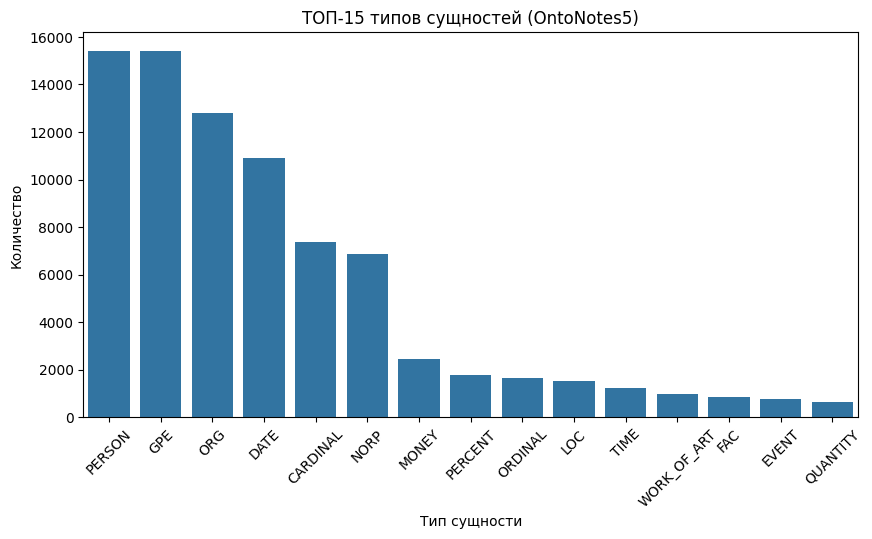

In [13]:
plt.figure(figsize=(10,5))
sns.barplot(x=[t for t,_ in type_counts.most_common(15)], y=[c for _,c in type_counts.most_common(15)])
plt.xticks(rotation=45)
plt.title("–¢–û–ü-15 —Ç–∏–ø–æ–≤ —Å—É—â–Ω–æ—Å—Ç–µ–π (OntoNotes5)")
plt.ylabel("–ö–æ–ª–∏—á–µ—Å—Ç–≤–æ")
plt.xlabel("–¢–∏–ø —Å—É—â–Ω–æ—Å—Ç–∏")
plt.show()

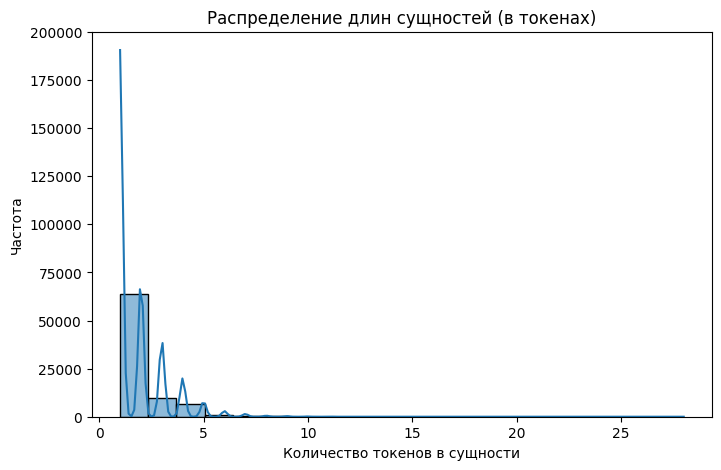

In [14]:
entity_lengths = [len(text.split()) for text, _ in all_ents]

plt.figure(figsize=(8,5))
sns.histplot(entity_lengths, bins=20, kde=True)
plt.title("–†–∞—Å–ø—Ä–µ–¥–µ–ª–µ–Ω–∏–µ –¥–ª–∏–Ω —Å—É—â–Ω–æ—Å—Ç–µ–π (–≤ —Ç–æ–∫–µ–Ω–∞—Ö)")
plt.xlabel("–ö–æ–ª–∏—á–µ—Å—Ç–≤–æ —Ç–æ–∫–µ–Ω–æ–≤ –≤ —Å—É—â–Ω–æ—Å—Ç–∏")
plt.ylabel("–ß–∞—Å—Ç–æ—Ç–∞")
plt.show()

In [15]:
print("–°—Ä–µ–¥–Ω—è—è –¥–ª–∏–Ω–∞ —Å—É—â–Ω–æ—Å—Ç–∏ (–≤ —Ç–æ–∫–µ–Ω–∞—Ö):", np.mean(entity_lengths))
print("–ú–µ–¥–∏–∞–Ω–∞ –¥–ª–∏–Ω—ã —Å—É—â–Ω–æ—Å—Ç–∏:", np.median(entity_lengths))
print("–ú–∞–∫—Å. –¥–ª–∏–Ω–∞ —Å—É—â–Ω–æ—Å—Ç–∏:", np.max(entity_lengths))


–°—Ä–µ–¥–Ω—è—è –¥–ª–∏–Ω–∞ —Å—É—â–Ω–æ—Å—Ç–∏ (–≤ —Ç–æ–∫–µ–Ω–∞—Ö): 1.8249376741457692
–ú–µ–¥–∏–∞–Ω–∞ –¥–ª–∏–Ω—ã —Å—É—â–Ω–æ—Å—Ç–∏: 1.0
–ú–∞–∫—Å. –¥–ª–∏–Ω–∞ —Å—É—â–Ω–æ—Å—Ç–∏: 28


In [16]:
def print_examples_with_entities(df, n=10):
    printed = 0
    for _, row in df.iterrows():
        ents = extract_entities_from_bio(row["tokens"], row["labels"])
        if ents:
            print("TEXT:", row["text"])
            print("ENTITIES:", ents)
            print("-" * 80)
            printed += 1
            if printed >= n:
                break

print_examples_with_entities(df_train, n=30)

TEXT: But a chance to fill out sales - tax records is rarely one of them .
ENTITIES: [('one', 'CARDINAL', 12, 13)]
--------------------------------------------------------------------------------
TEXT: Last week , Sen. Malcolm Wallop -LRB- R. , Wyo . -RRB- held hearings on a bill to strengthen an existing law designed to reduce regulatory hassles for small businesses .
ENTITIES: [('Last week', 'DATE', 0, 2), ('Malcolm Wallop', 'PERSON', 4, 6), ('R.', 'NORP', 7, 8), ('Wyo .', 'GPE', 9, 11)]
--------------------------------------------------------------------------------
TEXT: `` A great many federal regulations are meant for larger entities and do n't really apply to small businesses , '' says Marian Jacob , a legislative aide to Sen. Wallop .
ENTITIES: [('Marian Jacob', 'PERSON', 22, 24), ('Wallop', 'PERSON', 30, 31)]
--------------------------------------------------------------------------------
TEXT: Other lawmakers are busy trying to revive the recently lapsed Paperwork Reduction A

In [17]:

words_with_types = []
for (text, typ) in all_ents:
    words_with_types.append((text, typ))

word_counts = Counter([w for w, typ in words_with_types])

print("–¢–û–ü-30 —Å–ª–æ–≤ –≤–Ω—É—Ç—Ä–∏ —Å—É—â–Ω–æ—Å—Ç–µ–π:")
for w, c in word_counts.most_common(300):

    types_for_word = [typ for word, typ in words_with_types if word == w]

    most_common_type = Counter(types_for_word).most_common(1)[0][0]
    all_types = ', '.join(set(types_for_word))
    
    print(f"{w:20} {c:4} —Ç–∏–ø: {most_common_type}")

–¢–û–ü-30 —Å–ª–æ–≤ –≤–Ω—É—Ç—Ä–∏ —Å—É—â–Ω–æ—Å—Ç–µ–π:
China                1014 —Ç–∏–ø: GPE
two                   998 —Ç–∏–ø: CARDINAL
one                   916 —Ç–∏–ø: CARDINAL
Taiwan                914 —Ç–∏–ø: GPE
first                 829 —Ç–∏–ø: ORDINAL
U.S.                  754 —Ç–∏–ø: GPE
today                 563 —Ç–∏–ø: DATE
US                    558 —Ç–∏–ø: GPE
Chinese               493 —Ç–∏–ø: NORP
Israeli               434 —Ç–∏–ø: NORP
three                 415 —Ç–∏–ø: CARDINAL
Japan                 393 —Ç–∏–ø: GPE
American              384 —Ç–∏–ø: NORP
Bush                  366 —Ç–∏–ø: PERSON
Iraq                  365 —Ç–∏–ø: GPE
Palestinian           349 —Ç–∏–ø: NORP
Japanese              310 —Ç–∏–ø: NORP
New York              284 —Ç–∏–ø: GPE
Israel                270 —Ç–∏–ø: GPE
Washington            266 —Ç–∏–ø: GPE
second                260 —Ç–∏–ø: ORDINAL
Xinhua News Agency    241 —Ç–∏–ø: ORG
Palestinians          229 —Ç–∏–ø: NORP
Taiwanese             229 —Ç–∏–ø: NORP
fo

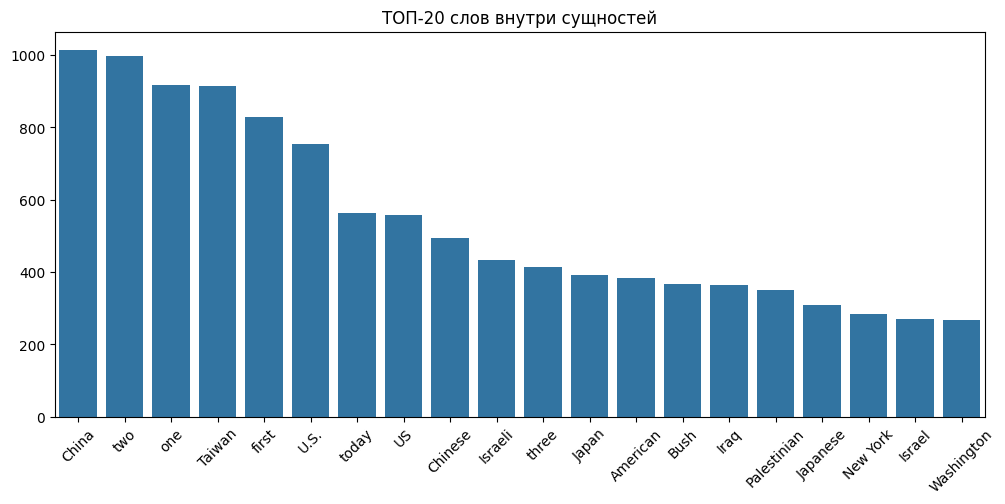

In [18]:
plt.figure(figsize=(12,5))
topn = 20
sns.barplot(x=[w for w,_ in word_counts.most_common(topn)], y=[c for _,c in word_counts.most_common(topn)])
plt.xticks(rotation=45)
plt.title("–¢–û–ü-20 —Å–ª–æ–≤ –≤–Ω—É—Ç—Ä–∏ —Å—É—â–Ω–æ—Å—Ç–µ–π")
plt.show()

# Spacy –±–µ–∑ –ø–∞—Ç—Ç–µ—Ä–Ω–æ–≤

In [19]:
from spacy.language import Language
import spacy

nlp = spacy.load("en_core_web_sm")


In [20]:
sample_df = df_train #.sample(10000, random_state=42)

In [21]:


def apply_rule_based_ner(text):
    """–ü—Ä–∏–º–µ–Ω—è–µ—Ç spaCy pipeline —Å –Ω–∞—à–∏–º–∏ –ø—Ä–∞–≤–∏–ª–∞–º–∏ –∏ –≤–æ–∑–≤—Ä–∞—â–∞–µ—Ç —Å—É—â–Ω–æ—Å—Ç–∏."""
    doc = nlp(text)
    return [(ent.text, ent.label_, ent.start_char, ent.end_char) for ent in doc.ents]


predicted_entities = []
gold_entities = []

results = []
for _, row in tqdm(sample_df.iterrows(), total=len(sample_df)):
    pred_ents = apply_rule_based_ner(row["text"])
    predicted_entities.append(pred_ents)

    # Gold (–∏—Å—Ç–∏–Ω–Ω—ã–µ —Å—É—â–Ω–æ—Å—Ç–∏)
    gold_ents = extract_entities_from_bio(row["tokens"], row["labels"])
    gold_entities.append(gold_ents)


def entities_to_bio(tokens, entities):
    """
    –ü—Ä–∞–≤–∏–ª—å–Ω–æ –ø—Ä–µ–æ–±—Ä–∞–∑—É–µ—Ç —Å—É—â–Ω–æ—Å—Ç–∏ –≤ BIO-—Ä–∞–∑–º–µ—Ç–∫—É.
    """
    tags = ["O"] * len(tokens)
    
    for ent_text, label, start_char, end_char in entities:

        ent_words = ent_text.split()
        

        for i in range(len(tokens) - len(ent_words) + 1):

            if tokens[i:i+len(ent_words)] == ent_words:

                tags[i] = "B-" + label
                for j in range(1, len(ent_words)):
                    tags[i + j] = "I-" + label
                break  
    
    return tags

gold_tags_all, pred_tags_all = [], []

for i, row in enumerate(sample_df.itertuples()):
    gold_tags = row.labels
    pred_tags = entities_to_bio(row.tokens, predicted_entities[i])
    gold_tags_all.extend(gold_tags)
    pred_tags_all.extend(pred_tags)

valid_labels = [t for t in gold_tags_all if t != "O"]
print("\n–û—Ç—á—ë—Ç –ø–æ rule-based NER (–ø–æ —Ç–æ–∫–µ–Ω–∞–º):\n")
print(classification_report(gold_tags_all, pred_tags_all, labels=list(set(valid_labels))[:10], zero_division=0))

100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 59924/59924 [04:55<00:00, 202.56it/s]



–û—Ç—á—ë—Ç –ø–æ rule-based NER (–ø–æ —Ç–æ–∫–µ–Ω–∞–º):

              precision    recall  f1-score   support

    B-PERSON       0.95      0.94      0.95     15429
    I-PERSON       0.95      0.94      0.95     11147
       B-ORG       0.91      0.91      0.91     12820
   I-PERCENT       0.94      0.95      0.95      2498
     B-MONEY       0.93      0.92      0.92      2411
  I-LANGUAGE       1.00      0.08      0.14        13
   B-ORDINAL       0.85      0.93      0.89      1640
   B-PRODUCT       0.90      0.77      0.83       606
   B-PERCENT       0.95      0.93      0.94      1763
      B-TIME       0.73      0.80      0.76      1233

   micro avg       0.93      0.93      0.93     49560
   macro avg       0.91      0.82      0.82     49560
weighted avg       0.93      0.93      0.93     49560



Precision, Recall, F1 –ø–æ —Å—É—â–Ω–æ—Å—Ç—è–º:

              precision    recall  f1-score   support

    CARDINAL       0.86      0.86      0.86      7367
        DATE       0.85      0.90      0.87     10922
       EVENT       0.80      0.68      0.73       748
         FAC       0.77      0.64      0.70       860
         GPE       0.95      0.92      0.93     15405
    LANGUAGE       0.86      0.69      0.77       304
         LAW       0.73      0.58      0.64       282
         LOC       0.84      0.80      0.82      1514
       MONEY       0.92      0.90      0.91      2434
        NORP       0.95      0.91      0.93      6870
     ORDINAL       0.85      0.93      0.89      1640
         ORG       0.88      0.89      0.89     12820
     PERCENT       0.94      0.92      0.93      1763
      PERSON       0.94      0.93      0.94     15429
     PRODUCT       0.88      0.76      0.82       606
    QUANTITY       0.85      0.79      0.82       657
        TIME       0.71      0.77

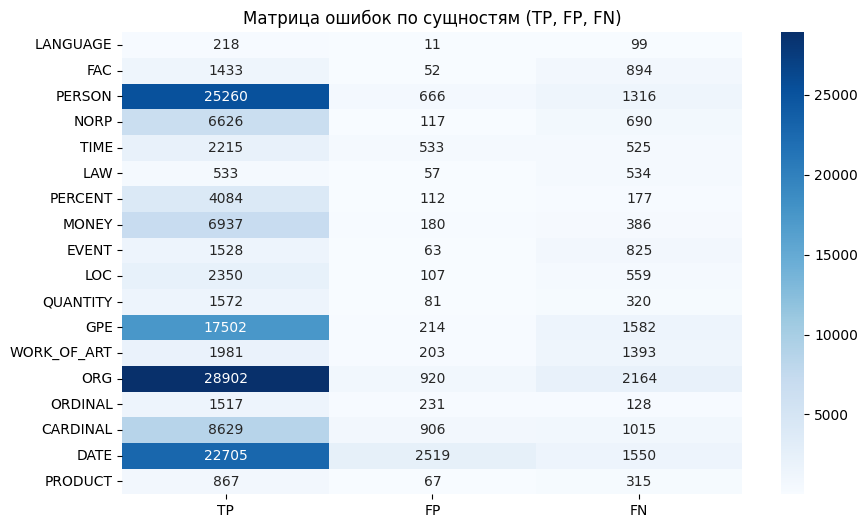

In [22]:

gold_tags_seq = [row.labels for row in sample_df.itertuples()]
pred_tags_seq = [entities_to_bio(row.tokens, predicted_entities[i]) for i, row in enumerate(sample_df.itertuples())]

print("Precision, Recall, F1 –ø–æ —Å—É—â–Ω–æ—Å—Ç—è–º:\n")
print(seq_classification_report(gold_tags_seq, pred_tags_seq, zero_division=0))


entity_types = list(set([tag[2:] for doc in gold_tags_seq for tag in doc if tag != "O"]))
TP = defaultdict(int)
FP = defaultdict(int)
FN = defaultdict(int)

for gold_doc, pred_doc in zip(gold_tags_seq, pred_tags_seq):
    for g, p in zip(gold_doc, pred_doc):
        g_type = g[2:] if g != "O" else None
        p_type = p[2:] if p != "O" else None

        if g_type == p_type and g_type is not None:
            TP[g_type] += 1
        elif g_type is None and p_type is not None:
            FP[p_type] += 1
        elif g_type is not None and p_type != g_type:
            FN[g_type] += 1

error_matrix = pd.DataFrame(index=entity_types, columns=["TP","FP","FN"])
for e in entity_types:
    error_matrix.loc[e] = [TP.get(e,0), FP.get(e,0), FN.get(e,0)]

plt.figure(figsize=(10,6))
sns.heatmap(error_matrix.astype(int), annot=True, fmt="d", cmap="Blues")
plt.title("–ú–∞—Ç—Ä–∏—Ü–∞ –æ—à–∏–±–æ–∫ –ø–æ —Å—É—â–Ω–æ—Å—Ç—è–º (TP, FP, FN)")
plt.show()

## –ö–∞–∫ –≤–∏–¥–Ω–æ –ø–æ –º–∞—Ç—Ä–∏—Ü–µ –∏ –º–µ—Ç—Ä–∏–∫–∞–º Spacy –∏–∑ –∫–æ—Ä–æ–±–∫–∏ –¥–∞–µ—Ç —Ö–æ—Ä–æ—à–∏–π —Ä–µ–∑—É–ª—å—Ç–∞—Ç

## –ü—Ä–æ–∞–Ω–∞–ª–∏–∑–∏—Ä—É–µ–º –Ω–µ –Ω–∞–π–¥–µ–Ω–Ω—ã–µ –∏–ª–∏ –Ω–∞–π–¥–µ–Ω–Ω—ã–µ –Ω–æ –Ω–µ–≤–µ—Ä–Ω–æ —Å—É—â–Ω–æ—Å—Ç–∏ –∏ –∏—Å—Ö–æ–¥—è –∏–∑ —ç—Ç–æ–≥–æ –¥–æ–±–∞–≤–∏–º –ø—Ä–∞–≤–∏–ª–∞ –ø–æ–¥ –Ω–∞—à –¥–∞—Ç–∞—Å–µ—Ç

In [23]:
from collections import defaultdict, Counter

def extract_entities(tokens, tags):
    """
    –°–æ–±–∏—Ä–∞–µ—Ç —Å—É—â–Ω–æ—Å—Ç–∏ –∏–∑ BIO-—Ä–∞–∑–º–µ—Ç–∫–∏:
    –í–æ–∑–≤—Ä–∞—â–∞–µ—Ç —Å–ø–∏—Å–æ–∫ (entity_text, entity_type)
    """
    entities = []
    current_tokens = []
    current_type = None
    
    for tok, tag in zip(tokens, tags):
        
        if tag.startswith("B-"):
            # –Ω–æ–≤–∞—è —Å—É—â–Ω–æ—Å—Ç—å
            if current_tokens:
                entities.append((" ".join(current_tokens), current_type))
            current_tokens = [tok]
            current_type = tag[2:]
        elif tag.startswith("I-") and current_type == tag[2:]:
            current_tokens.append(tok)
        else:
            if current_tokens:
                entities.append((" ".join(current_tokens), current_type))
                current_tokens = []
                current_type = None
    if current_tokens:
        entities.append((" ".join(current_tokens), current_type))
    return entities

def get_fn_from_entitie(entitie):
    # ---- –°–±–æ—Ä FN ----
    fn_entities = []

    for gold_doc, pred_doc, row in zip(gold_tags_seq, pred_tags_seq, sample_df.itertuples()):
        gold_entities = set(extract_entities(row.tokens, gold_doc))
        pred_entities = set(extract_entities(row.tokens, pred_doc))
        
        # FN = —Ç–µ, —á—Ç–æ –µ—Å—Ç—å –≤ gold, –Ω–æ –Ω–µ—Ç –≤ –ø—Ä–µ–¥—Å–∫–∞–∑–∞–Ω–Ω—ã—Ö
        missed = gold_entities - pred_entities
        fn_entities.extend(missed)

    # ---- –í–´–í–û–î –¢–û–õ–¨–ö–û –î–õ–Ø entitie ----
    print("=== FALSE NEGATIVES –¢–û–õ–¨–ö–û –î–õ–Ø entitie ===\n")

    # –§–∏–ª—å—Ç—Ä—É–µ–º —Ç–æ–ª—å–∫–æ entitie —Å—É—â–Ω–æ—Å—Ç–∏
    fn_org_entities = [(text, typ) for text, typ in fn_entities if typ == entitie]
    fn_org_counts = Counter(fn_org_entities)

    print("üîπ False Negatives entitie (—Å—É—â–Ω–æ—Å—Ç–∏, –∫–æ—Ç–æ—Ä—ã—Ö –Ω–µ –Ω–∞—à–ª–∏):")
    for (ent_text, ent_type), count in fn_org_counts.most_common(50):
        print(f"{ent_text:<40} ‚Üí {ent_type} ({count})")

    print(f"\nüî∏ –í—Å–µ–≥–æ –ø—Ä–æ–ø—É—â–µ–Ω–æ entitie —Å—É—â–Ω–æ—Å—Ç–µ–π: {len(fn_org_entities)}")
    print(f"üî∏ –£–Ω–∏–∫–∞–ª—å–Ω—ã—Ö entitie —Å—É—â–Ω–æ—Å—Ç–µ–π: {len(fn_org_counts)}")

    # ---- –î–û–ü–û–õ–ù–ò–¢–ï–õ–¨–ù–ê–Ø –°–¢–ê–¢–ò–°–¢–ò–ö–ê –ü–û entitie ----
    print(f"\nüìä –°—Ç–∞—Ç–∏—Å—Ç–∏–∫–∞ –ø–æ –¥–ª–∏–Ω–µ –ø—Ä–æ–ø—É—â–µ–Ω–Ω—ã—Ö entitie —Å—É—â–Ω–æ—Å—Ç–µ–π:")
    length_stats = defaultdict(int)
    for text, _ in fn_org_entities:
        word_count = len(text.split())
        length_stats[word_count] += 1

    for word_count, count in sorted(length_stats.items()):
        print(f"  {word_count} —Å–ª–æ–≤(–∞): {count} —Å—É—â–Ω–æ—Å—Ç–µ–π")

    # ---- –°–ê–ú–´–ï –ß–ê–°–¢–´–ï –ü–†–û–ü–£–©–ï–ù–ù–´–ï entitie ----
    print(f"\nüèÜ –¢–û–ü-20 —Å–∞–º—ã—Ö —á–∞—Å—Ç—ã—Ö –ø—Ä–æ–ø—É—â–µ–Ω–Ω—ã—Ö entitie:")
    for (ent_text, ent_type), count in fn_org_counts.most_common(20):
        print(f"  {count:3} √ó '{ent_text}'")

In [24]:
get_fn_from_entitie('DATE')

=== FALSE NEGATIVES –¢–û–õ–¨–ö–û –î–õ–Ø entitie ===

üîπ False Negatives entitie (—Å—É—â–Ω–æ—Å—Ç–∏, –∫–æ—Ç–æ—Ä—ã—Ö –Ω–µ –Ω–∞—à–ª–∏):
year                                     ‚Üí DATE (23)
now                                      ‚Üí DATE (18)
day                                      ‚Üí DATE (9)
years                                    ‚Üí DATE (9)
week                                     ‚Üí DATE (8)
1970s                                    ‚Üí DATE (7)
Today                                    ‚Üí DATE (7)
days                                     ‚Üí DATE (6)
mid-1980s                                ‚Üí DATE (6)
1980s                                    ‚Üí DATE (6)
Now                                      ‚Üí DATE (5)
next year                                ‚Üí DATE (5)
Monday                                   ‚Üí DATE (5)
decade                                   ‚Üí DATE (5)
one day                                  ‚Üí DATE (5)
Thursday                                 ‚Üí DATE (4)


In [25]:
get_fn_from_entitie('ORG')

=== FALSE NEGATIVES –¢–û–õ–¨–ö–û –î–õ–Ø entitie ===

üîπ False Negatives entitie (—Å—É—â–Ω–æ—Å—Ç–∏, –∫–æ—Ç–æ—Ä—ã—Ö –Ω–µ –Ω–∞—à–ª–∏):
Washington                               ‚Üí ORG (9)
the White House                          ‚Üí ORG (8)
American                                 ‚Üí ORG (8)
Senate                                   ‚Üí ORG (7)
State                                    ‚Üí ORG (6)
PRC                                      ‚Üí ORG (6)
Wall Street Journal                      ‚Üí ORG (5)
Pentagon                                 ‚Üí ORG (5)
Wall Street                              ‚Üí ORG (5)
VIA                                      ‚Üí ORG (5)
New York Times                           ‚Üí ORG (5)
Congress                                 ‚Üí ORG (4)
EU                                       ‚Üí ORG (4)
the United Nations                       ‚Üí ORG (4)
Hollywood                                ‚Üí ORG (4)
National Taiwan University               ‚Üí ORG (4)
the Shihkang Work 

In [26]:
from collections import Counter, defaultdict

def get_fp_from_entitie(entitie):
    # ---- –°–±–æ—Ä FP ----
    fp_entities = []

    for gold_doc, pred_doc, row in zip(gold_tags_seq, pred_tags_seq, sample_df.itertuples()):
        gold_entities = set(extract_entities(row.tokens, gold_doc))
        pred_entities = set(extract_entities(row.tokens, pred_doc))
        
        # FP = —Ç–æ, —á—Ç–æ –Ω–∞–π–¥–µ–Ω–æ, –Ω–æ –Ω–µ –±—ã–ª–æ –≤ gold
        extra = pred_entities - gold_entities
        fp_entities.extend(extra)

    # ---- –í–´–í–û–î –¢–û–õ–¨–ö–û –î–õ–Ø entitie ----
    print(f"=== FALSE POSITIVES –¢–û–õ–¨–ö–û –î–õ–Ø {entitie} ===\n")

    # –§–∏–ª—å—Ç—Ä—É–µ–º —Ç–æ–ª—å–∫–æ entitie —Å—É—â–Ω–æ—Å—Ç–∏
    fp_org_entities = [(text, typ) for text, typ in fp_entities if typ == entitie]
    fp_org_counts = Counter(fp_org_entities)

    print(f"üîπ False Positives {entitie} (–ª–∏—à–Ω–∏–µ —Å—É—â–Ω–æ—Å—Ç–∏, –∫–æ—Ç–æ—Ä—ã—Ö –Ω–µ –±—ã–ª–æ –≤ gold):")
    for (ent_text, ent_type), count in fp_org_counts.most_common(50):
        print(f"{ent_text:<40} ‚Üí {ent_type} ({count})")

    print(f"\nüî∏ –í—Å–µ–≥–æ –ª–∏—à–Ω–∏—Ö {entitie} —Å—É—â–Ω–æ—Å—Ç–µ–π: {len(fp_org_entities)}")
    print(f"üî∏ –£–Ω–∏–∫–∞–ª—å–Ω—ã—Ö FP {entitie} —Å—É—â–Ω–æ—Å—Ç–µ–π: {len(fp_org_counts)}")

    # ---- –î–û–ü–û–õ–ù–ò–¢–ï–õ–¨–ù–ê–Ø –°–¢–ê–¢–ò–°–¢–ò–ö–ê –ü–û entitie ----
    print(f"\nüìä –°—Ç–∞—Ç–∏—Å—Ç–∏–∫–∞ –ø–æ –¥–ª–∏–Ω–µ –ª–∏—à–Ω–∏—Ö {entitie} —Å—É—â–Ω–æ—Å—Ç–µ–π:")
    length_stats_fp = defaultdict(int)
    for text, _ in fp_org_entities:
        word_count = len(text.split())
        length_stats_fp[word_count] += 1

    for word_count, count in sorted(length_stats_fp.items()):
        print(f"  {word_count} —Å–ª–æ–≤(–∞): {count} —Å—É—â–Ω–æ—Å—Ç–µ–π")

    # ---- –°–ê–ú–´–ï –ß–ê–°–¢–´–ï FP entitie ----
    print(f"\nüèÜ –¢–û–ü-20 —Å–∞–º—ã—Ö —á–∞—Å—Ç—ã—Ö –ª–∏—à–Ω–∏—Ö entitie:")
    for (ent_text, ent_type), count in fp_org_counts.most_common(20):
        print(f"  {count:3} √ó '{ent_text}'")


In [27]:
get_fp_from_entitie('DATE')

=== FALSE POSITIVES –¢–û–õ–¨–ö–û –î–õ–Ø DATE ===

üîπ False Positives DATE (–ª–∏—à–Ω–∏–µ —Å—É—â–Ω–æ—Å—Ç–∏, –∫–æ—Ç–æ—Ä—ã—Ö –Ω–µ –±—ã–ª–æ –≤ gold):
today                                    ‚Üí DATE (127)
annual                                   ‚Üí DATE (44)
the day                                  ‚Üí DATE (44)
Today                                    ‚Üí DATE (24)
daily                                    ‚Üí DATE (24)
tomorrow                                 ‚Üí DATE (23)
this year                                ‚Üí DATE (22)
yesterday                                ‚Üí DATE (22)
years                                    ‚Üí DATE (20)
each year                                ‚Üí DATE (18)
the years                                ‚Üí DATE (16)
one day                                  ‚Üí DATE (16)
the year                                 ‚Üí DATE (15)
Christmas                                ‚Üí DATE (15)
annually                                 ‚Üí DATE (13)
last year                  

## –ü—Ä–∞–≤–∏–ª–∞ –ø–æ–¥ –Ω–∞—à –¥–∞—Ç–∞—Å–µ—Ç:

In [37]:
from spacy.language import Language
import spacy

nlp = spacy.load("en_core_web_sm")

ruler = nlp.add_pipe("entity_ruler", before="ner")
patterns = []
# DATE
date_patterns = [
    {
        "label": "DATE",
        "pattern": [
            {"TEXT": {"IN": [
                "Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday",
                "Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"
            ]}}
        ]
    },
]

# ORG
ORGS = [
    "WSJ", "Bush administration","The New York Times", "New York Times", "Wall Street Journal", 
    "G-2", "Hall of Fame", "Hamas", "Homeland Security", "IAFP", "PFP",
    "U.S.A. Today", "Jeffrey Group", "Ito Bureau",  "TMD", 
    "Theater Missile Defense", "Supreme Court", "FmHA", "FIFA",
    "Socialist Unity Party", "Iraqi Republican Guard", 
    "Special Administrative Region", "McDonalds", "Taiwanese Affairs Office",
    "People's Bank of China", "Puerto Rico Telephone Co.", "Bei Shun",
    "Reuters", "Philip Morris Cos.", "Wal-Mart", "Michael and Victor",
    "Times-Dispatch", "Star Newspaper", "African National Assembly",
    "Phoenix program", "Shihkang Newsletter", "Warsaw Pact", 
    "Seismology Bureau", "Palestinian Liberation Organization",
    "European and American Affairs Department", "Roy Rogers", "VIA",
    "al-Jazirah", "Arthur Andersen", "National Development Bank",
    "Rural Solidarity", "University of Illinois in Chicago", 
    "Taiwan Affairs Office", "Pentagon", "Washington", "White House",
    
]
org_patterns = []

for org in ORGS:

    # 1Ô∏è‚É£ –û—Å–Ω–æ–≤–Ω–æ–µ –Ω–∞–∑–≤–∞–Ω–∏–µ
    org_patterns.append({"label": "ORG", "pattern": org})

    # 2Ô∏è‚É£ –° –∞—Ä—Ç–∏–∫–ª–µ–º "the"
    org_patterns.append({"label": "ORG", "pattern": f"the {org}"})
    org_patterns.append({"label": "ORG", "pattern": f"The {org}"})

    # 3Ô∏è‚É£ –° possessive 's
    org_patterns.append({"label": "ORG", "pattern": f"{org} 's"})




patterns.extend(date_patterns)  
patterns.extend(org_patterns)
ruler.add_patterns(patterns)


In [38]:
text = "The New York Times reported a story about Wall Street Journal."
doc2 = nlp(text)
for ent in doc2.ents:
    print(ent.text, "‚Üí", ent.label_)

The New York Times ‚Üí ORG
Wall Street Journal ‚Üí ORG


In [39]:

predicted_entities = []
gold_entities = []

results = []
for _, row in tqdm(sample_df.iterrows(), total=len(sample_df)):
    pred_ents = apply_rule_based_ner(row["text"])
    predicted_entities.append(pred_ents)
    # Gold (–∏—Å—Ç–∏–Ω–Ω—ã–µ —Å—É—â–Ω–æ—Å—Ç–∏)
    gold_ents = extract_entities_from_bio(row["tokens"], row["labels"])
    gold_entities.append(gold_ents)





gold_tags_all, pred_tags_all = [], []

for i, row in enumerate(sample_df.itertuples()):
    gold_tags = row.labels
    pred_tags = entities_to_bio(row.tokens, predicted_entities[i])
    gold_tags_all.extend(gold_tags)
    pred_tags_all.extend(pred_tags)

valid_labels = [t for t in gold_tags_all if t != "O"]
print("\n–û—Ç—á—ë—Ç –ø–æ rule-based NER (–ø–æ —Ç–æ–∫–µ–Ω–∞–º):\n")
print(classification_report(gold_tags_all, pred_tags_all, labels=list(set(valid_labels))[:10], zero_division=0))

100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 59924/59924 [04:56<00:00, 202.04it/s]



–û—Ç—á—ë—Ç –ø–æ rule-based NER (–ø–æ —Ç–æ–∫–µ–Ω–∞–º):

              precision    recall  f1-score   support

    B-PERSON       0.95      0.94      0.95     15429
    I-PERSON       0.95      0.94      0.94     11147
       B-ORG       0.87      0.91      0.89     12820
   I-PERCENT       0.94      0.95      0.95      2498
     B-MONEY       0.93      0.92      0.92      2411
  I-LANGUAGE       1.00      0.08      0.14        13
   B-ORDINAL       0.85      0.93      0.89      1640
   B-PRODUCT       0.90      0.77      0.83       606
   B-PERCENT       0.95      0.93      0.94      1763
      B-TIME       0.72      0.78      0.75      1233

   micro avg       0.92      0.93      0.92     49560
   macro avg       0.91      0.81      0.82     49560
weighted avg       0.92      0.93      0.92     49560



Precision, Recall, F1 –ø–æ —Å—É—â–Ω–æ—Å—Ç—è–º:

              precision    recall  f1-score   support

    CARDINAL       0.86      0.86      0.86      7367
        DATE       0.83      0.89      0.86     10922
       EVENT       0.80      0.68      0.73       748
         FAC       0.77      0.59      0.67       860
         GPE       0.95      0.90      0.93     15405
    LANGUAGE       0.86      0.69      0.77       304
         LAW       0.73      0.57      0.64       282
         LOC       0.84      0.79      0.82      1514
       MONEY       0.92      0.90      0.91      2434
        NORP       0.95      0.91      0.93      6870
     ORDINAL       0.85      0.93      0.89      1640
         ORG       0.84      0.88      0.86     12820
     PERCENT       0.94      0.92      0.93      1763
      PERSON       0.94      0.93      0.93     15429
     PRODUCT       0.88      0.76      0.82       606
    QUANTITY       0.85      0.79      0.82       657
        TIME       0.69      0.75

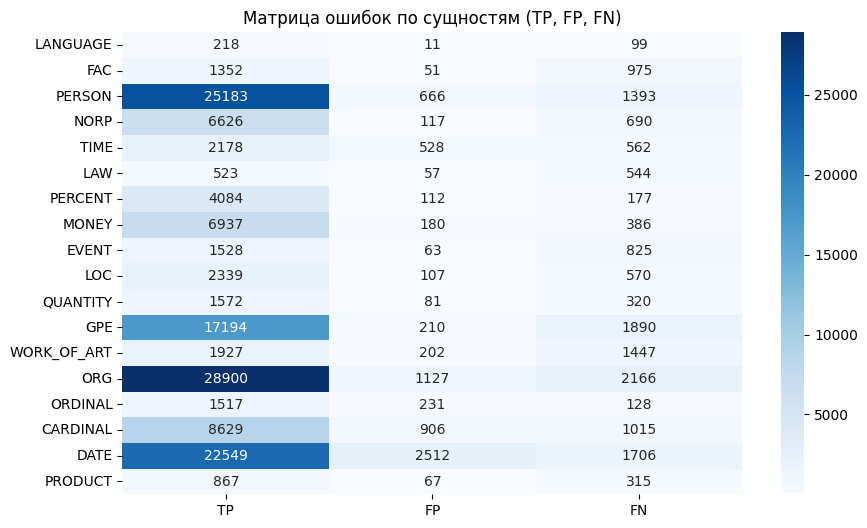

In [40]:

gold_tags_seq = [row.labels for row in sample_df.itertuples()]
pred_tags_seq = [entities_to_bio(row.tokens, predicted_entities[i]) for i, row in enumerate(sample_df.itertuples())]

print("Precision, Recall, F1 –ø–æ —Å—É—â–Ω–æ—Å—Ç—è–º:\n")
print(seq_classification_report(gold_tags_seq, pred_tags_seq, zero_division=0))


entity_types = list(set([tag[2:] for doc in gold_tags_seq for tag in doc if tag != "O"]))
TP = defaultdict(int)
FP = defaultdict(int)
FN = defaultdict(int)

for gold_doc, pred_doc in zip(gold_tags_seq, pred_tags_seq):
    for g, p in zip(gold_doc, pred_doc):
        g_type = g[2:] if g != "O" else None
        p_type = p[2:] if p != "O" else None

        if g_type == p_type and g_type is not None:
            TP[g_type] += 1
        elif g_type is None and p_type is not None:
            FP[p_type] += 1
        elif g_type is not None and p_type != g_type:
            FN[g_type] += 1

error_matrix = pd.DataFrame(index=entity_types, columns=["TP","FP","FN"])
for e in entity_types:
    error_matrix.loc[e] = [TP.get(e,0), FP.get(e,0), FN.get(e,0)]

plt.figure(figsize=(10,6))
sns.heatmap(error_matrix.astype(int), annot=True, fmt="d", cmap="Blues")
plt.title("–ú–∞—Ç—Ä–∏—Ü–∞ –æ—à–∏–±–æ–∫ –ø–æ —Å—É—â–Ω–æ—Å—Ç—è–º (TP, FP, FN)")
plt.show()

In [41]:
# False Negatives (–Ω–µ –Ω–∞—à–ª–∏ —Å—É—â–Ω–æ—Å—Ç—å)
fn_examples = []
for i, (gold_doc, pred_doc, row) in enumerate(zip(gold_tags_seq, pred_tags_seq, sample_df.itertuples())):
    for t_gold, t_pred, tok in zip(gold_doc, pred_doc, row.tokens):
        if t_gold != "O" and t_pred == "O":
            fn_examples.append((tok, t_gold))

fn_pairs = [(tok, t_gold[2:]) for tok, t_gold in fn_examples]

fn_pair_counts = Counter(fn_pairs)
fn_by_type = Counter([ent_type for _, ent_type in fn_pairs])

print("üîπ False Negatives –ø–æ —Ç–æ–∫–µ–Ω–∞–º –∏ —Ç–∏–ø–∞–º (—Ç–æ–ø-50):")
for (tok, ent_type), count in fn_pair_counts.most_common(10):
    print(f"{tok:<20} ‚Üí {ent_type:<10} ({count})")

print("\nüî∏ False Negatives –ø–æ —Ç–∏–ø–∞–º —Å—É—â–Ω–æ—Å—Ç–µ–π:")
for ent_type, count in fn_by_type.most_common(10):
    print(f"{ent_type:<10} ‚Äî {count}")


üîπ False Negatives –ø–æ —Ç–æ–∫–µ–Ω–∞–º –∏ —Ç–∏–ø–∞–º (—Ç–æ–ø-50):
one                  ‚Üí CARDINAL   (238)
China                ‚Üí GPE        (135)
the                  ‚Üí DATE       (115)
Taiwan               ‚Üí GPE        (93)
the                  ‚Üí ORG        (83)
Chinese              ‚Üí NORP       (75)
"                    ‚Üí WORK_OF_ART (67)
two                  ‚Üí CARDINAL   (57)
the                  ‚Üí PERSON     (52)
year                 ‚Üí DATE       (50)

üî∏ False Negatives –ø–æ —Ç–∏–ø–∞–º —Å—É—â–Ω–æ—Å—Ç–µ–π:
ORG        ‚Äî 1405
DATE       ‚Äî 1373
GPE        ‚Äî 1140
PERSON     ‚Äî 924
WORK_OF_ART ‚Äî 905
CARDINAL   ‚Äî 706
NORP       ‚Äî 491
TIME       ‚Äî 342
EVENT      ‚Äî 300
LAW        ‚Äî 223


In [42]:

fp_examples = []
for i, (gold_doc, pred_doc, row) in enumerate(zip(gold_tags_seq, pred_tags_seq, sample_df.itertuples())):
    for t_gold, t_pred, tok in zip(gold_doc, pred_doc, row.tokens):
        if t_gold == "O" and t_pred != "O":
            fp_examples.append((tok, t_pred))
fp_counts = Counter([tok for tok, t_pred in fp_examples])

fp_pairs = [(tok, t_pred[2:]) for tok, t_pred in fp_examples] 


fp_pair_counts = Counter(fp_pairs)


fp_by_type = Counter([ent_type for _, ent_type in fp_pairs])

print("False Positives –ø–æ —Ç–æ–∫–µ–Ω–∞–º –∏ —Ç–∏–ø–∞–º (—Ç–æ–ø-50):")
for (tok, ent_type), count in fp_pair_counts.most_common(10):
    print(f"{tok:<20} ‚Üí {ent_type:<10} ({count})")

print("\nFalse Positives –ø–æ —Ç–∏–ø–∞–º —Å—É—â–Ω–æ—Å—Ç–µ–π:")
for ent_type, count in fp_by_type.most_common(10):
    print(f"{ent_type:<10} ‚Äî {count}")

False Positives –ø–æ —Ç–æ–∫–µ–Ω–∞–º –∏ —Ç–∏–ø–∞–º (—Ç–æ–ø-50):
the                  ‚Üí ORG        (314)
the                  ‚Üí DATE       (309)
one                  ‚Üí CARDINAL   (222)
first                ‚Üí ORDINAL    (170)
year                 ‚Üí DATE       (158)
day                  ‚Üí DATE       (150)
-RRB-                ‚Üí PERSON     (133)
today                ‚Üí DATE       (118)
a                    ‚Üí DATE       (112)
years                ‚Üí DATE       (104)

False Positives –ø–æ —Ç–∏–ø–∞–º —Å—É—â–Ω–æ—Å—Ç–µ–π:
DATE       ‚Äî 2512
ORG        ‚Äî 1127
CARDINAL   ‚Äî 906
PERSON     ‚Äî 666
TIME       ‚Äî 528
ORDINAL    ‚Äî 231
GPE        ‚Äî 210
WORK_OF_ART ‚Äî 202
MONEY      ‚Äî 180
NORP       ‚Äî 117


In [43]:
get_fn_from_entitie('DATE')

=== FALSE NEGATIVES –¢–û–õ–¨–ö–û –î–õ–Ø entitie ===

üîπ False Negatives entitie (—Å—É—â–Ω–æ—Å—Ç–∏, –∫–æ—Ç–æ—Ä—ã—Ö –Ω–µ –Ω–∞—à–ª–∏):
year                                     ‚Üí DATE (23)
now                                      ‚Üí DATE (18)
day                                      ‚Üí DATE (9)
years                                    ‚Üí DATE (9)
last Thursday                            ‚Üí DATE (8)
week                                     ‚Üí DATE (8)
1970s                                    ‚Üí DATE (7)
Today                                    ‚Üí DATE (7)
late Monday                              ‚Üí DATE (6)
days                                     ‚Üí DATE (6)
mid-1980s                                ‚Üí DATE (6)
1980s                                    ‚Üí DATE (6)
Now                                      ‚Üí DATE (5)
next Tuesday                             ‚Üí DATE (5)
next year                                ‚Üí DATE (5)
late Tuesday                             ‚Üí DATE (5)


In [44]:
get_fn_from_entitie('ORG')

=== FALSE NEGATIVES –¢–û–õ–¨–ö–û –î–õ–Ø entitie ===

üîπ False Negatives entitie (—Å—É—â–Ω–æ—Å—Ç–∏, –∫–æ—Ç–æ—Ä—ã—Ö –Ω–µ –Ω–∞—à–ª–∏):
Pentagon                                 ‚Üí ORG (63)
the Washington Post                      ‚Üí ORG (11)
American                                 ‚Üí ORG (8)
The Washington Post                      ‚Üí ORG (7)
The Wall Street Journal 's               ‚Üí ORG (7)
Senate                                   ‚Üí ORG (7)
Washington Post                          ‚Üí ORG (7)
White House                              ‚Üí ORG (6)
State                                    ‚Üí ORG (6)
PRC                                      ‚Üí ORG (6)
Wall Street Journal                      ‚Üí ORG (5)
IAFP                                     ‚Üí ORG (5)
the Supreme Court 's                     ‚Üí ORG (5)
Supreme Court                            ‚Üí ORG (5)
Wall Street                              ‚Üí ORG (5)
Washington                               ‚Üí ORG (5)
New York Times  

In [45]:
get_fp_from_entitie('DATE')

=== FALSE POSITIVES –¢–û–õ–¨–ö–û –î–õ–Ø DATE ===

üîπ False Positives DATE (–ª–∏—à–Ω–∏–µ —Å—É—â–Ω–æ—Å—Ç–∏, –∫–æ—Ç–æ—Ä—ã—Ö –Ω–µ –±—ã–ª–æ –≤ gold):
today                                    ‚Üí DATE (127)
Sun                                      ‚Üí DATE (50)
annual                                   ‚Üí DATE (44)
the day                                  ‚Üí DATE (44)
Friday                                   ‚Üí DATE (37)
Tuesday                                  ‚Üí DATE (35)
Monday                                   ‚Üí DATE (31)
Saturday                                 ‚Üí DATE (26)
Today                                    ‚Üí DATE (24)
daily                                    ‚Üí DATE (24)
tomorrow                                 ‚Üí DATE (23)
this year                                ‚Üí DATE (22)
yesterday                                ‚Üí DATE (22)
Sunday                                   ‚Üí DATE (21)
Wednesday                                ‚Üí DATE (20)
Thursday                   

# –í—ã–≤–æ–¥—ã:
1) –ò–∑ –∫–æ—Ä–æ–±–∫–∏ spacy —Å –¥–∞–Ω–Ω—ã–º –¥–∞—Ç–∞—Å–µ—Ç–æ–º —Å–ø—Ä–∞–≤–ª—è–µ—Ç—Å—è –æ—Ç–ª–∏—á–Ω–æ
2) –ü–æ–ø—ã—Ç–∫–∏ —É–ª—É—á—à–∏—Ç—å —Ä–µ–∑—É–ª—å—Ç–∞—Ç—ã —Å–≤–æ–∏–º–∏ –ø–∞—Ç—Ç–µ—Ä–Ω–∞–º–∏ —Ç–æ–ª—å–∫–æ —É—Ö—É–¥—à–∞—é—Ç –º–µ—Ç—Ä–∏–∫–∏